# Instructions

- This assignment was posted on 23 October, 2024 and is due on 8 November 2024, at 11:59 pm
- Answer all questions in this Jupyter notebook skeleton within the provided cells. Questions will indicate whether the answer should take the form of a coded or written response. Use the dropdown menu within the Jupyter interface to toggle between 'Markdown' or 'Code' for the cells. Do NOT delete or rearrange any of the question blocks within this skeleton.
- The following two files should be submitted to LEARN:
    - This IPYNB file containing the questions and your answers in either code or markdown.
    - A PDF printout of this IPYNB file. To generate this, first run and save the output of all cells. Then expand all cells and print as PDF. Be sure that all your code and answers are visible in the PDF document you submit. 
- The total number of marks for this assignment is 100.

## Exercise 1. Decision Trees

### EXERCISE1-TASK1: [10 marks]
Implement a decision tree algorithm from scratch using a binary splitting structure, taking the Gini Index as the loss.

To receive full marks, your code should meet the following requirements:
- Allow for classification in the multiclass setting. Note that the Gini Index loss covered in class 
\begin{align}
l = \sum_{k=1}^c \hat p_{mk}(1 - \hat p_{mk})
\end{align}
where $\hat p_{mk}$ is the empirical fraction of samples in some region $m$ of the space belonging to class $k$ out of $c$ total class labels, is general to the number of classes c.
- The maximum depth of the decision tree can be controlled through a user-selected parameter
- The implementation is positioned for application as part of the Random Forest algorithm, and implements two feature subsampling methods, to randomly select from $m < p$ input features for determining the best split, for each split in the tree-building process. In other words, each split evaluate only the selected subset of features. Specifically, allow for the user to select from $m=p$ (no subsampling), $m = p/2$, and $m=\sqrt{p}$ features.
- A stopping criterion has been selected from those covered in class, such as reaching the maximum depth, pure leaf nodes, or a minimal number of samples. You may also apply mutiple stopping criteria together, as is often done in practice. Add a comment in your code to indicate which criteria you have chosen.

In [11]:
### SOLUTION BLOCK ###
### YOUR CODE GOES HERE ###

import numpy as np
from dataclasses import dataclass
from collections import Counter

@dataclass
class Node:
    split_idx: int = None
    split_threshold: float = None
    left: 'Node' = None
    right: 'Node' = None
    value: int = None

class DecisionTree:
    def __init__(self, max_depth=None, feature_subsampling='none'):
        self.max_depth = max_depth
        self.feature_subsampling = feature_subsampling
        self.n_classes = None
        self.n_features = None
        self.tree = None
        
    def gini_loss(self, y):
        if len(y) == 0:
            return 0
        probabilities = np.bincount(y, minlength=self.n_classes) / len(y) 
        loss = np.sum(probabilities * (1 - probabilities))
        return loss
    
    def _feature_subsampling(self):
        if self.feature_subsampling == 'none':
            return self.n_features
        elif self.feature_subsampling == 'half':
            return max(1, self.n_features // 2)
        elif self.feature_subsampling == 'sqrt':
            return max(1, int(np.sqrt(self.n_features)))
    
    def split_tree(self, x, y):
        if len(y) <= 1:
            return None
        
        n_subsampled_features = self._feature_subsampling()
        idxs = np.random.choice(self.n_features, n_subsampled_features, replace=False)
        
        best_loss = 1.0
        best_feature = None
        
        for idx in idxs:
            thresholds = np.unique(x[:, idx])
            
            for threshold in thresholds:
                left_mask = x[:, idx] <= threshold
                right_mask = ~left_mask
                
                loss_left = self.gini_loss(y[left_mask])
                loss_right = self.gini_loss(y[right_mask])
                
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                loss = (n_left * loss_left + n_right * loss_right) / len(y)
                
                if loss < best_loss:
                    best_loss = loss
                    best_feature = {
                        "idx": idx,
                        "threshold": threshold,
                        "loss": loss
                    }
        
        return best_feature 
    
    def build_tree_recursive(self, x, y, depth=0):
        if len(y) == 0:
            return Node(value=0)

        if depth >= self.max_depth or len(np.unique(y)) <= 1:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        best_feature = self.split_tree(x, y)
        
        if best_feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
            
        idx = best_feature["idx"]
        threshold = best_feature["threshold"]
        
        left_mask = x[:, idx] <= threshold
        right_mask = ~left_mask
        
        left_subtree = self.build_tree_recursive(x[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree_recursive(x[right_mask], y[right_mask], depth + 1)
        
        return Node(
            split_idx=idx,
            split_threshold=threshold,
            left=left_subtree,
            right=right_subtree
        )
    
    def fit(self, x, y):
        self.n_classes = len(np.unique(y))
        self.n_features = x.shape[1] 
        self.tree = self.build_tree_recursive(x, y)
     
    def predict(self, x):
        def recurse(x, node):
            if node.value is not None:
                return node.value
            
            if x[node.split_idx] <= node.split_threshold:
                return recurse(x, node.left)
            else:
                return recurse(x, node.right)
        
        return np.array([recurse(x_i, self.tree) for x_i in x])


### EXERCISE1-TASK2 [10 marks]:
Fit a decision tree to the Iris dataset, using a 67%/33% train/test split. Visualize the performance of your tree on the test dataset using a multiclass confusion matrix (you may use methods from `sklearn.metrics` for this part. Compare your performance to the implementation from `sklearn.tree.DecisionTreeClassifier`, and comment on any discrepancies in behavior.

Custom accuracy: 0.94
Sklearn accuracy: 0.98


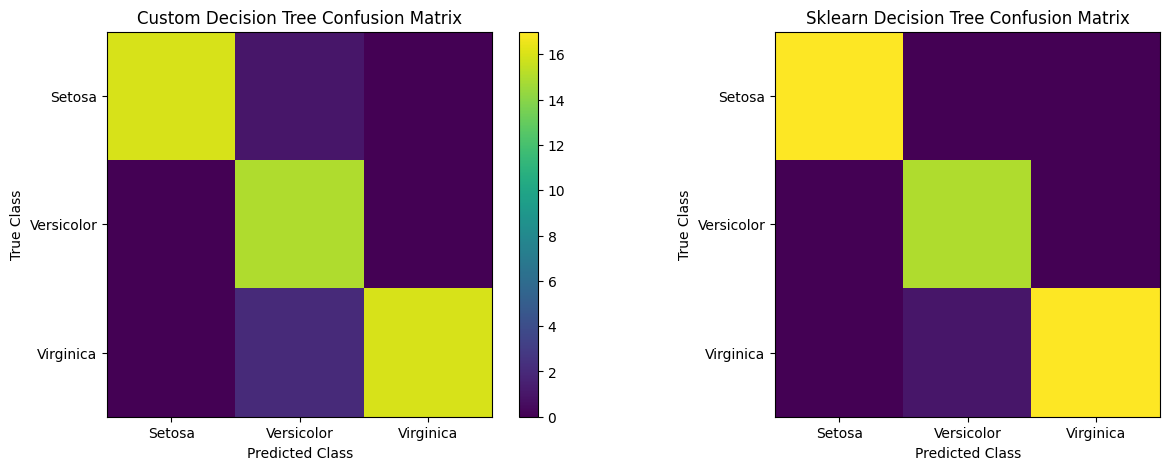

In [13]:
### SOLUTION BLOCK ###
### YOUR CODE GOES HERE ###

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

data = pd.read_csv('iris.csv')

x = data[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']].values
label_map = {name: idx for idx, name in enumerate(data['variety'].unique())}
y = data['variety'].map(label_map).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

decision_tree = DecisionTree(max_depth=5, feature_subsampling='half')
decision_tree.fit(x_train, y_train)
preds = decision_tree.predict(x_test)
accuracy = accuracy_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

sklearn_decision_tree = DecisionTreeClassifier()
sklearn_decision_tree.fit(x_train, y_train)
sklearn_preds = sklearn_decision_tree.predict(x_test)
sklearn_acc = accuracy_score(y_test, sklearn_preds)
sklearn_cm = confusion_matrix(y_test, sklearn_preds)

print(f"Custom accuracy: {accuracy}")
print(f"Sklearn accuracy: {sklearn_acc}")

min_val = min(np.min(cm), np.min(sklearn_cm))
max_val = max(np.max(cm), np.max(sklearn_cm))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

colorbar = fig.colorbar(ax1.imshow(cm, vmin=min_val, vmax=max_val), ax=ax1)

ax1.imshow(cm, vmin=min_val, vmax=max_val)
ax1.set_title("Custom Decision Tree Confusion Matrix")
ax1.set_xticks(np.arange(len(label_map)))
ax1.set_yticks(np.arange(len(label_map)))
ax1.set_xticklabels(label_map.keys())
ax1.set_yticklabels(label_map.keys())
ax1.set_xlabel("Predicted Class")
ax1.set_ylabel("True Class")

ax2.imshow(sklearn_cm, vmin=min_val, vmax=max_val)
ax2.set_title("Sklearn Decision Tree Confusion Matrix")
ax2.set_xticks(np.arange(len(label_map)))
ax2.set_yticks(np.arange(len(label_map)))
ax2.set_xticklabels(label_map.keys())
ax2.set_yticklabels(label_map.keys())
ax2.set_xlabel("Predicted Class")
ax2.set_ylabel("True Class")

plt.show()

In [14]:
# The performance is almost identical

### EXERCISE1-TASK3 [10 marks]:

Explore the performance of your Random Forest algorithm implementation on the `heart.csv` dataset using your implementation from **EXERCISE1-TASK1**, over a range of number of trees and with different methods of feature subsampling.

Detailed instructions: First, begin by loading the heart disease dataset stored in `heart.csv`. Note that this dataset has categorial columns ("cp" and "restecg"), that must be converted to one-hot encoded columns. The labels, that indicate the presence or absence of heart disease, are stored in the "target" column that you will aim to predict. Split the dataset into disjoint training set (66%) and a testing set (33%).

Next, explore a Random Forest with each of `[1,2,5,10,20,50,100,200,500,1000]` number of trees, and for each of the cases of $m = p$, $m = p/2$, and $m = \sqrt(p)$. Set the maximum depth for an individual tree to 5. For each combination of hyperparameter settings, build your decision tree using the training set and evaluate its performance on the testing dataset, and store the test classification error for later plotting.

Generate a plot of `Test Classification Error` as a function of `Number of Trees`, with separate line plots for each of the three feature subsampling methods. (e.g. the setup of your figure should correspond to that of Figure 8.10 in *Introduction to Statistical Learning*.

none
1
2
5
10
20
50
100
200
500
1000
half
1
2
5
10
20
50
100
200
500
1000
sqrt
1
2
5
10
20
50
100
200
500
1000


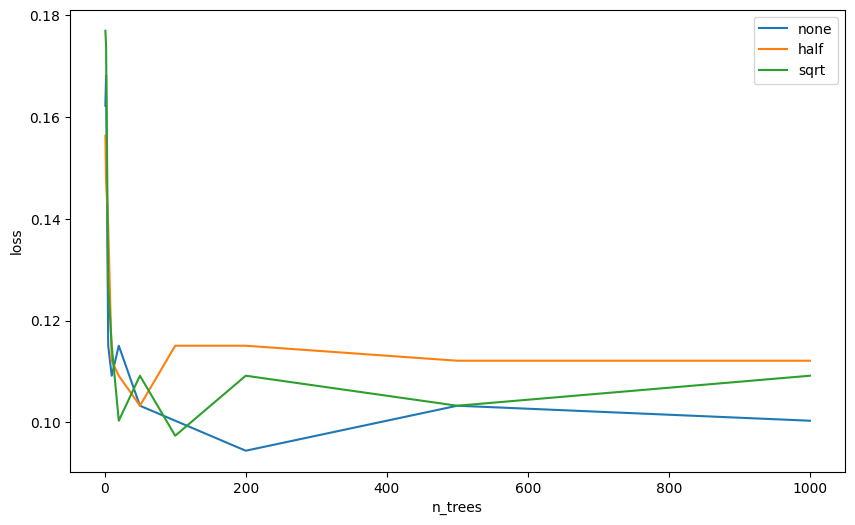

In [19]:
### SOLUTION BLOCK ###
### YOUR CODE GOES HERE ###

class RandomForest:
    def __init__(self, n_trees, feature_subsampling):
        self.n_trees = n_trees
        self.feature_subsampling = feature_subsampling
        
        self.trees = []
        
    def fit(self, x, y):
        self.trees = []
        n_samples = x.shape[0]
        
        for _ in range(self.n_trees):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            x_bootstrap = x[indices]
            y_bootstrap = y[indices]
            
            tree = DecisionTree(max_depth=5, feature_subsampling=self.feature_subsampling)
            tree.fit(x_bootstrap, y_bootstrap)
            self.trees.append(tree)
            
    def predict(self, x):
        preds = np.array([tree.predict(x) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 
                                 axis=0, arr=preds)


df = pd.read_csv('heart.csv')
df = pd.get_dummies(df, columns=['cp', 'restecg'])

xs = df.drop(columns=['target']).values.astype(float)
ys = df['target'].values.astype(int)

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33)

n_trees_vals = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
feature_sampling_vals = ['none', 'half', 'sqrt']

results = {}

for method in feature_sampling_vals:
    print(f"{method}")
    results[method] = []
    for n_trees in n_trees_vals:
        print(f"{n_trees}")
        random_forest = RandomForest(n_trees=n_trees, feature_subsampling=method)
        random_forest.fit(x_train, y_train)
        y_pred = random_forest.predict(x_test)
        loss = np.mean(y_pred != y_test)
        results[method].append(loss)

plt.figure(figsize=(10, 6))
for method in feature_sampling_vals:
    plt.plot(n_trees_vals, results[method], label=method)
plt.xlabel('n_trees')
plt.ylabel('loss')
plt.legend()
plt.show()

## Exercise 2. Bias-Variance Decomposition
In class, we analyzed a regression problem of predicting a continuous random variable $Y \in \mathbb{R}$ which is an unknown function $f: \;\; \mathbb{R}^d \to \mathbb{R}$ of $X \in \mathbb{R}^d$ corrupted by Gaussian noise $\epsilon \sim \mathcal{N}(\mu = 0, \sigma_{\epsilon}^2)$
\begin{align*}
Y &= f(X) + \epsilon\\
\end{align*}
and saw how the implications of decomposing expected error on the test dataset into the three components that we labelled irreducible error, squared bias, and variance.

### **EXERCISE2-TASK1: [10 marks]**
For this regression setup, show that the expectation of the squared error for some new test input $x_t$:
\begin{align*}
\textrm{Err}(x_t) &= \mathbb{E}\left[ (Y - \hat{f}(x_t))^2 \mid X = x_t \right] \\
\end{align*}
May be expressed as
\begin{align*}
\textrm{Err}(x_t) &= \sigma_{\epsilon}^2 + \left[ \mathbb{E}[\hat{f}(x_t)] - f(x_t) \right]^2 + \mathbb{E}\left[ \left( \hat{f}(x_t) - \mathbb{E}[\hat{f}(x_t)] \right)^2 \right].
\end{align*}

Where $\hat f(x)$ denotes our approximated function.

----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------

Write your solution here using the built-in support for MathJax and Markdown.


\begin{align*}
  Err(x_t) &= \mathbb{E}\left[ (Y - \hat{f}(x_t))^2 \mid X = x_t \right] \\
  &= \mathbb{E}\left[ (f(x_t) + \epsilon - \hat{f}(x_t))^2 \mid X = x_t \right] \\
  &= \mathbb{E} \left[ \left( f(x_t) + \epsilon - \hat{f}(x_t) + \mathbb{E} [ \hat{f}(x_t) ] - \mathbb{E} [ \hat{f}(x_t) ] \right)^2 \mid X = x_t \right] \text{Adding + subtracting } \mathbb{E} [ \hat{f}(x_t) ] \\
  &= \mathbb{E} \left[ \left( \left( f(x_t) - \mathbb{E} [ \hat{f}(x_t) ] \right) + \left( \mathbb{E} [ \hat{f}(x_t) ] - \hat{f}(x_t) \right) + \epsilon \right)^2 \mid X = x_t \right] \\
  &= \mathbb{E} \left[
    \left( f(x_t) - \mathbb{E} [ \hat{f}(x_t) ] \right)^2 +  
    \left( \mathbb{E} [ \hat{f}(x_t) ] - \hat{f}(x_t) \right)^2 +  
    \left( \epsilon \right)^2 +  \text{(cross terms)}
\right] \\
  & \mathbb{E}[\epsilon(f(x_t) - \mathbb{E}[\hat{f}(x_t)])] = 0 \text{ (since } \mathbb{E}[\epsilon] = 0 \text{)} \\
  & \mathbb{E}[\epsilon(\mathbb{E}[\hat{f}(x_t)] - \hat{f}(x_t))] = 0 \text{ (since } \mathbb{E}[\epsilon] = 0 \text{)} \\
  & \mathbb{E}[(f(x_t) - \mathbb{E}[\hat{f}(x_t)])(\mathbb{E}[\hat{f}(x_t)] - \hat{f}(x_t))] = 0 \text{ (since } f(x_t) - \mathbb{E}[\hat{f}(x_t)] \text{is a constant)} \\
  Err(x_t) &= \mathbb{E} \left[
    \left( f(x_t) - \mathbb{E} [ \hat{f}(x_t) ] \right)^2 +  
    \left( \mathbb{E} [ \hat{f}(x_t) ] - \hat{f}(x_t) \right)^2 +  
    \left( \epsilon \right)^2 
  \right] \\
  &= \mathbb{E} \left[ \left( f(x_t) - \mathbb{E} [ \hat{f}(x_t) ] \right)^2 \right] +  
    \mathbb{E} \left[ \left( \mathbb{E} [ \hat{f}(x_t) ] - \hat{f}(x_t) \right)^2 \right] +  
    \mathbb{E} \left[ \left( \epsilon \right)^2 \right] \text{ (linearity of expectation)} \\
  &= \left( f(x_t) - \mathbb{E} [ \hat{f}(x_t) ] \right)^2 +  
    \mathbb{E} \left[ \left( \mathbb{E} [ \hat{f}(x_t) ] - \hat{f}(x_t) \right)^2 \right] +  
    \mathbb{E} \left[ \left( \epsilon \right)^2 \right] \text{ (linearity of expectation)} \\
  \mathbb{E} \left[ \left( \epsilon \right)^2 \right] &= \sigma_{\epsilon}^2 \text{ (by def)} \\
  & (f(x_t) - \mathbb{E}[\hat{f}(x_t)])^2 = (\mathbb{E}[\hat{f}(x_t)] - f(x_t))^2 \text{ (symmetric since squared)} \\
  & \mathbb{E} \left[ \left( \mathbb{E}[\hat{f}(x_t)] - \hat{f}(x_t) \right)^2 \right] = \mathbb{E} \left[ \left( \hat{f}(x_t) - \mathbb{E}[\hat{f}(x_t)] \right)^2 \right] \text{ (symmetric since squared)} \\
  Err(x_t) &= \sigma_{\epsilon}^2 + \left[ \mathbb{E}[\hat{f}(x_t)] - f(x_t) \right]^2 + \mathbb{E}\left[ \left( \hat{f}(x_t) - \mathbb{E}[\hat{f}(x_t)] \right)^2 \right].
\end{align*}


----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------



## Exercise 3. Bagging with Correlated Samples
(Adapted from Exercise 15.1 in *Elements of Statistical Learning*) A critical assumption underpinning bootstrap aggregation is that pairwise correlations between model errors is low. However, independent bootstrap realizations will not be perfectly decorrelated, and so the actual variance reduction achieved in practice will be much less. In this task you will explore the variance reduction when samples are not independent, that is, they are correlated. 

### **EXERCISE3-TASK1: [10 marks]**
In class, we found that given $Bn$ independent draws from a normal distribution (i.e. $x_i \sim_{i.i.d} \mathcal{N}(\mu,\sigma^2)$), the variance of the estimate of the mean was $\frac{1}{Bn}\sigma^2$.
Suppose you have a set of $B$ random variables that are identically distributed, but not independent; that is, they have some positive pairwise correlation coefficient $\rho > 0$. Show that the variance of the estimate of the mean of $B$ random variables is given by:
\begin{align*}
\rho \sigma^2 + \frac{1-p}{B}\sigma^2
\end{align*}


----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------

Write your solution here using the built-in support for MathJax and Markdown.

$$
\begin{align*}
\bar{X} &= \frac{1}{B} \sum_{i=1}^B X_i, X_i \sim \mathcal{N}(\mu, \sigma^2) \\
& \text{Corr}(X_i, X_j) = \rho \\
\text{Var}(\bar{X}) &= \text{Var} \left( \frac{1}{B} \sum_{i=1}^B X_i \right) \\
&= \frac{1}{B^2} \text{Var} \left( \sum_{i=1}^B X_i \right) \\
&= \frac{1}{B^2} \left[ \sum_{i=1}^B \text{Var}(X_i) + \sum_{i\neq j} \text{Cov}(X_i, X_j) \right] \text{linearity of var} \\
&= \frac{1}{B^2} \left[ B \sigma^2 + \sum_{i \neq j} \rho \sigma^2 \right] \\
&= \frac{1}{B^2} \left[ B \sigma^2 + B(B-1) \rho \sigma^2 \right] \\
&= \frac{\sigma^2}{B^2} \left[ B + B (B-1) \rho \right] \\
&= \frac{\sigma^2}{B^2} \left[ B + B^2 \rho - B \rho \right] \\
&= \frac{\sigma^2}{B^2} \left[ B(1 - \rho) + B^2 \rho \right] \\
&= \frac{\sigma^2 (1 - \rho)}{B} + \rho \sigma^2 \\
\end{align*}
$$

----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------

## Exercise 4. Gaussian Mixture Models

### EXERCISE4-TASK 1 [10 marks]:
Qualitatively reproduce Figure 9.5 in *Pattern Recognition and Machine Learning*. That is, generate a 3-panel plot to visualize samples from the a) joint distribution and b) marginal distributions of a 3-component, 2D gaussian mixture model, as well as c) the "responsibility" of each component $k$ in explaining each sample drawn.

You may use `scipy.stats.multivariate_normal` to define the PDF and draw samples from individual components. Assume the following parameters for the GMM:
\begin{align}
\mu_1 &= (0.5,0.5), \Sigma_1 = \begin{bmatrix} 0.02 & -0.01 \\ -0.01 & 0.02 \end{bmatrix}\\
\mu_2 &= (0.8,0.6), \Sigma_1 = \begin{bmatrix} 0.02 & 0.01 \\ 0.01 & 0.02 \end{bmatrix}\\
\mu_3 &= (0.1,0.4), \Sigma_1 = \begin{bmatrix} 0.02 & 0.01 \\ 0.01 & 0.02 \end{bmatrix}\\
\end{align}

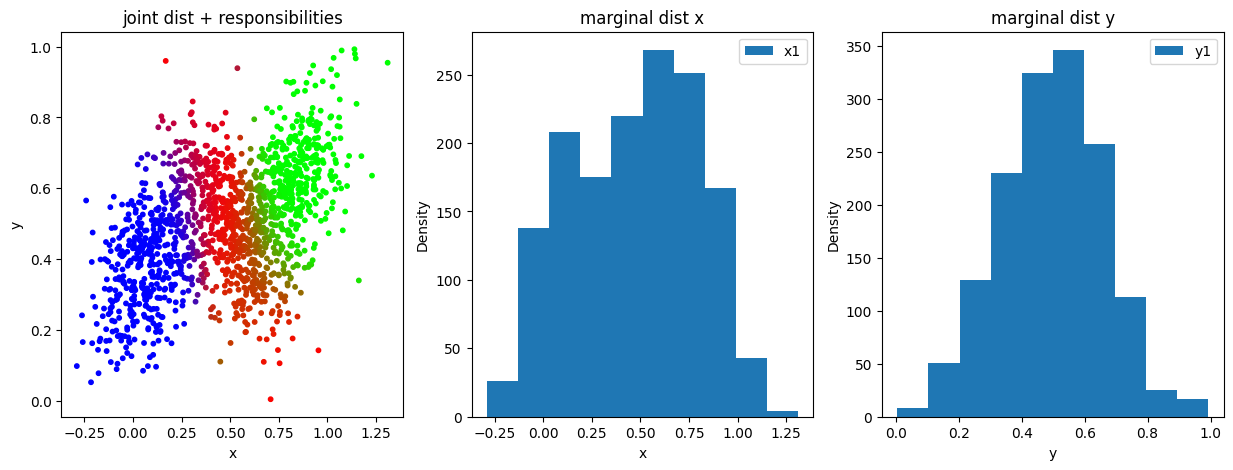

In [26]:
### SOLUTION BLOCK ###
### YOUR CODE GOES HERE ###

from scipy.stats import multivariate_normal

mu1 = np.array([0.5, 0.5])
mu2 = np.array([0.8, 0.6])
mu3 = np.array([0.1, 0.4])

sigma1 = np.array([[0.02, -0.01], [-0.01, 0.02]])
sigma2 = np.array([[0.02, 0.01], [0.01, 0.02]])
sigma3 = np.array([[0.02, 0.01], [0.01, 0.02]])

n = 500 

x1, y1 = multivariate_normal.rvs(mean=mu1, cov=sigma1, size=n).T
x2, y2 = multivariate_normal.rvs(mean=mu2, cov=sigma2, size=n).T
x3, y3 = multivariate_normal.rvs(mean=mu3, cov=sigma3, size=n).T

x = np.concatenate([x1, x2, x3])
y = np.concatenate([y1, y2, y3])

responsibilities = np.zeros((3, 3 * n))
for i in range(3 * n):
    p1 = multivariate_normal.pdf([x[i], y[i]], mean=mu1, cov=sigma1)
    p2 = multivariate_normal.pdf([x[i], y[i]], mean=mu2, cov=sigma2)
    p3 = multivariate_normal.pdf([x[i], y[i]], mean=mu3, cov=sigma3)
    total = p1 + p2 + p3
    responsibilities[:, i] = [p1 / total, p2 / total, p3 / total]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(x, y, c=responsibilities.T, s=10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('joint dist + responsibilities')

axes[1].hist(x, label=['x1', 'x2', 'x3'])
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].set_title('marginal dist x')
axes[1].legend()

axes[2].hist(y, label=['y1', 'y2', 'y3'])
axes[2].set_xlabel('y')
axes[2].set_ylabel('Density')
axes[2].set_title('marginal dist y')
axes[2].legend()

plt.show()


## Exercise 5. Multilayer Perceptrons


### EXERCISE5-TASK1 [10 marks]:
Compute the derivative of the Mish activation function with respect to $x$
\begin{align}
\textrm{mish}(x) = x \cdot \textrm{tanh}( \textrm{log}(1+e^x) )
\end{align}

----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------

Write your solution here using the built-in support for MathJax and Markdown.

$$
\begin{align*}
\frac{d}{dx} \textrm{mish}(x) &= \frac{d}{dx} \left[ x \cdot \textrm{tanh}( \textrm{log}(1+e^x) ) \right] \\
&= x \cdot \frac{d}{dx} \left[ \textrm{tanh}( \textrm{log}(1+e^x) ) \right] + \textrm{tanh}( \textrm{log}(1+e^x) ) \cdot \frac{d}{dx} (x) \\
&= x \cdot \textrm{sech}^2(\textrm{log}(1+e^x)) \cdot \frac{d}{dx} [\textrm{log}(1+e^x)] + \textrm{tanh}( \textrm{log}(1+e^x) ) \cdot 1 \\
&= x \cdot \textrm{sech}^2(\textrm{log}(1+e^x)) \cdot \frac{1}{1+e^x} \cdot \frac{d}{dx}(1+e^x) + \textrm{tanh}( \textrm{log}(1+e^x) ) \\
&= x \cdot \textrm{sech}^2(\textrm{log}(1+e^x)) \cdot \frac{e^x}{1+e^x} + \textrm{tanh}( \textrm{log}(1+e^x) )
\end{align*}
$$
----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------

### EXERCISE5-TASK2 [10 marks]:
(Adapted from Exercise 5.1, *Dive into Deep Learning*) In class, we saw how adding layers to a linear deep network (a network without a nonlinearity) can never increase the expressive power of a network. Give an example where adding layers to a linear deep network reduces the expressive power of a network. 

----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------

Write your solution here using the built-in support for MathJax and Markdown.

Any case where we reduce then increase the width of each layer will reduce the expressivity of the nn.

e.g. a network that takes a 10d input, projects it to 1d, then projects it back to 10d will have less expressivity than a network that takes a 10d input and projects it to 10d since the first network can only represent linear relationships bc of the projection to 1d even though it has more layers (2 vs 1).

----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------

## Exercise 6. AdaBoost as Fitting an Additive Model

Our in-class discussion of AdaBoost did not provide a theoretical rationale for why it works.
The AdaBoost algorithm is in fact a specific case of *forward stagewise additive modeling*, which in turn is a way of fitting an *expansion set* of elementary *basis functions*. 

More generally, expansion set models are central to many advanced learning techniques and take the form
\begin{align}
f(x) = \sum_{m-1}^M \alpha_m g_m(x, \theta_m),
\end{align}
where $M$ is the number of basis functions, $\alpha_m$ is the weight of the $m^{th}$ classifier, and $\theta$ are its parameters. 

Such models are usually fit by minimizing some loss function $l$ over the training data to find estimates of the set of importance coefficients $\{ \hat \alpha_m\}$ and basis function parameters $\{ \hat \theta_m\}$. This is to say that
\begin{align}
\{ \hat \alpha_m, \hat \theta_m\}_1^M = \textrm{argmin}_{\{ \alpha_m, \theta_m\}_1^M}\sum_{i=1}^N l\Bigg(y_i,\sum_{m-1}^M \alpha_m g_m(x, \theta_m)\Bigg)
\end{align}

Forward stagewise additive modelling aproaches, like AdaBoost, instead find an approximate solution to this objective by adding basis functions in sequence. That is, at each iteration $m$, one estimates
\begin{align}
\hat \alpha_m, \hat \theta_m\ = 
\textrm{argmin}_{ \alpha_m, \theta_m\ }\sum_{i=1}^N l\Bigg(y_i, f_{m-1} + \alpha_m g_m(x, \theta_m)\Bigg)
\end{align}
which positions one to make predictions for $x$
\begin{align}
f_m(x) = f_{m-1}(x) + \alpha_m g_m(x, \theta_m)
\end{align}
In the case of applying AdaBoost to learn a binary classifier, these basis functions would be the base classifiers or members of the ensemble.

### EXERCISE6-TASK1 [20 marks]:
Show how the multiplicative weight update of AdaBoost
\begin{align}
w_i^{(m+1)} = w_i^{(m)}e^{\alpha_m \mathbb{1}(y_i \neq g_m(x_i))}
\end{align}
can be derived from the forward stagewise additive modelling technique for the special case of minimizing an exponential loss function
\begin{align}
l(y,f(x)) = \sum_{i=1}^N e^{-y_if(x_i)}
\end{align}
where $y \in \{ -1, +1\}$.

----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------

Write your solution here using the built-in support for MathJax and Markdown.

----------------------------------------------------------------------------------------------- Solution Block ----------------------------------------------------------------------------------------------